In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from scipy import ndimage
from scipy.ndimage import gaussian_filter

In [2]:
def initU(x,y,c):
    U=np.random.rand(x,y,c)
    rsum=U.sum(axis=2)
    NU = np.divide(U,rsum[:,:, None])
    return NU  #(x,y,c)

# def initB(x,y):
#     B=np.ones((x,y),dtype=np.float32)
#     BN=B*1e-3
#     return BN  #(x,y,c)

def initB(x, y, mean=0.0, std=1.0):
    """
    Initialize the bias matrix with a Gaussian distribution (mean=0, std=1 by default).
    
    Parameters:
    x (int): The number of rows (height).
    y (int): The number of columns (width).
    mean (float): The mean of the Gaussian distribution (default is 0).
    std (float): The standard deviation of the Gaussian distribution (default is 1).
    
    Returns:
    B (numpy array): A bias matrix initialized with Gaussian-distributed values.
    """
    B = np.random.normal(mean, std, (x, y))
    B_min = B.min()
    B_max = B.max()
    
    B_normalized = (B - B_min) / (B_max - B_min + 1e-10)
    return B  # (x, y)

def distmat(data,bias,cen,x,y,c):
    eps=1e-10
    temp=data-bias #(x,y)
    temp1=np.repeat(temp[:, :, None], repeats = c, axis=2) #(x,y,c)
    dist = np.zeros((x,y,c))
    for i in range(x):
        for j in range(y):
            for k in range(c):
                sum=(data[i, j] - bias[i, j] - cen[k])**2
                dist[i,j,k]=sum 
      # data1 =  np.repeat(data[:, :, None], repeats = c, axis=2)
      # dist = np.zeros((x,y,c))
      # repetitions = x*y
      # repeats_Cen = np.tile(cen, (repetitions, 1))
      # repeats_Cen = np.reshape(repeats_Cen,(x,y,c))
      # dist = (data1-repeats_Cen)**2
    return dist+eps

def meanfilter(dist,alpha,ws,c):
    new_data=[]
    kernel=np.ones((ws,ws),dtype=np.float32)
    
    kernel[ws//2][ws//2]=0
    kernel=kernel/((ws*ws) -1)
    for i in range(c):
        num=dist[:,:,i]
        temp=ndimage.convolve(num,kernel,mode='constant',cval=0.0)
        new_data.append(temp)
    mean_dist=np.stack(new_data,axis=2)
    return mean_dist
def meanfilterV(diff,alpha,ws,c):
    new_data=[]
    kernel=np.ones((ws,ws),dtype=np.float32)
    
    kernel[ws//2][ws//2]=0
    kernel=kernel/((ws*ws) -1)
    temp=ndimage.convolve(diff,kernel,mode='constant',cval=0.0)
    return temp

def updateU(data,bias,cen,alpha,m,ws,x,y,c):
    dist=distmat(data,bias,cen,x,y,c)
    mean_dist=meanfilter(dist,alpha,ws,c)
    num=(dist+(alpha*mean_dist))**((-1)/(m-1))
    denom=num.sum(axis=2)
    updatedU=num/denom[:,:,None]
    return updatedU

def updateB(U,data,cen,m,c):
    mf=U**(m)
    num=np.einsum('xyc,c->xy',mf,cen)
    denom=mf.sum(axis=2)
    temp=num/denom
    bias=data-temp
    return bias

def updateV(U,data,bias,alpha,m,ws,c):
    mf=U**(m)
    diff=data-bias
    mean_mat=meanfilterV(diff,alpha,ws,c)
    temp=diff+(alpha*mean_mat)
    temp1=np.repeat(temp[:, :, None], repeats = c, axis=2)
    temp2=temp1*mf
    num=temp2.sum(axis=1)#(x,c)
    num=num.sum(axis=0)#(1,c)
    denom=mf.sum(axis=1)
    denom=denom.sum(axis=0)
    denom=denom*(1+alpha)
    cen=num/denom
    cen=cen.T
    return cen

def objf(U,data,cen,bias,alpha,x,y,c):
    mf=U**(m)#(x,y,c)
    dist=distmat(data,bias,cen,x,y,c)#(x,y,c)
    mean_dist=meanfilter(dist,alpha,ws,c)#(x,y,c)
    temp1=mf*dist #(x,y,c)
    temp2=mf*mean_dist #(x,y,c)
    temp3=temp1 + (alpha*temp2)
    obj=temp3.sum(axis=2) #(x,y)
    obj=temp3.sum(axis=1) #(x,1)
    obj=temp3.sum() #(1)
    return obj

def BCFCM(data,alpha,c,m,ws,epochs):
    x,y=data.shape
    Uinit=initU(x,y,c)
    U=Uinit
    Binit=initB(x,y,mean=0.0, std=0.1)
    bias=Binit
    obj=[]
    olddiff=0.0
    for i in range(epochs):
        cen=updateV(U,data,bias,alpha,m,ws,c)
        UNew=updateU(data,bias,cen,alpha,m,ws,x,y,c)
        bias=updateB(UNew,data,cen,m,c)
        bias = gaussian_filter(bias, sigma=10)
        objval=objf(UNew,data,cen,bias,alpha,x,y,c)
        obj.append(objval)
        diff=((np.absolute(U-UNew)).sum(axis=1)).sum()
        print("Itteration ", i, "Differnce", diff)
        if (np.absolute(olddiff-diff)<0.001):
          break
        olddiff = diff
        U = UNew
    return U,cen,bias,obj

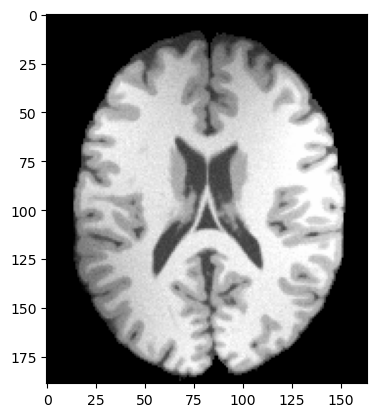

In [3]:
import matplotlib.pyplot as plt 
import matplotlib.image as img 
from PIL import Image
#testimage=img.read('photoshop_created_image5.png')
testimage=img.imread('brainweb90.tif')
# image_path = '\brain mri dataset sir\brainweb67.tif'
# # Open the image
# img = Image.open(image_path)
plt.imshow(testimage,cmap='gray')
plt.show()

In [4]:
import cv2
img_gray = cv2.cvtColor(testimage, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscale Image', img_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
print(img_gray.shape)

(189, 164)


In [6]:
print(np.unique(img_gray))

[  0   3   4   5   7   9  10  11  12  13  14  17  19  20  21  23  24  25
  26  27  28  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254]


In [7]:
data=img_gray
c=4
m=2
ws=3
alpha=0.1
epochs=1000
U,cen,bias,obj=BCFCM(data,alpha,c,m,ws,epochs)

Itteration  0 Differnce 14028.88316638953
Itteration  1 Differnce 4131.760724877501
Itteration  2 Differnce 5668.534067415099
Itteration  3 Differnce 10411.840157484614
Itteration  4 Differnce 14546.446147687808
Itteration  5 Differnce 12960.560417527955
Itteration  6 Differnce 8648.19071960517
Itteration  7 Differnce 5193.309725498757
Itteration  8 Differnce 3813.789509469225
Itteration  9 Differnce 3206.2809460923368
Itteration  10 Differnce 2781.305759585718
Itteration  11 Differnce 2493.1612078634935
Itteration  12 Differnce 2226.3929506595455
Itteration  13 Differnce 1955.675909495535
Itteration  14 Differnce 1757.114286067108
Itteration  15 Differnce 1641.428801017973
Itteration  16 Differnce 1547.8265476769584
Itteration  17 Differnce 1433.5816139658423
Itteration  18 Differnce 1284.5011361205059
Itteration  19 Differnce 1112.9489474910833
Itteration  20 Differnce 975.4285606305289
Itteration  21 Differnce 840.4311207224225
Itteration  22 Differnce 694.5590865644231
Itteration  

In [10]:
print(np.unique(U))

[1.05714868e-09 1.08587538e-09 1.70648707e-09 ... 9.99999982e-01
 9.99999989e-01 9.99999989e-01]


In [11]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,:,3]
# seg3 = np.reshape(seg3,img_gray.shape)

(189, 164, 4)


In [12]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m: np.mean(m))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Clusters after FCM')

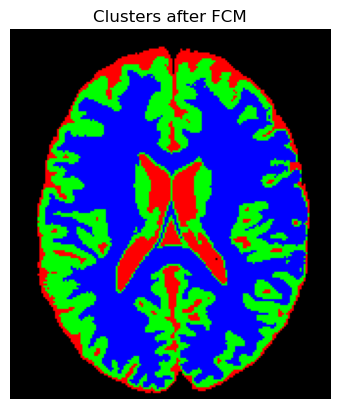

In [13]:
cmb=np.dstack((seg1,seg2*2,seg3*3))
plt.imshow(cmb,cmap='gray')
plt.axis('off')
plt.title('Clusters after FCM')

[]

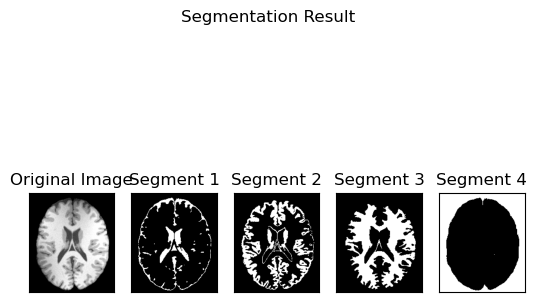

In [14]:
fig, axs = plt.subplots(1,5)
fig.suptitle('Segmentation Result')
axs[0].imshow(testimage,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])

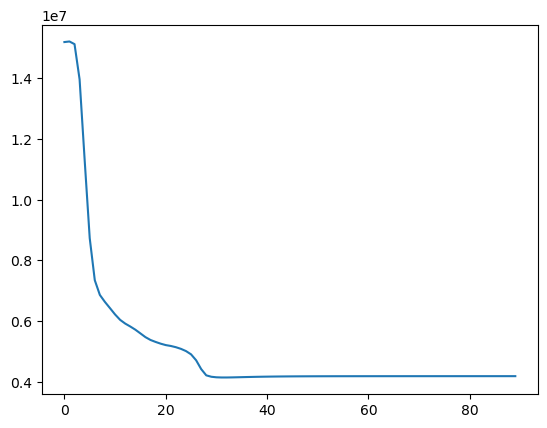

In [15]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(obj)

In [16]:
print(bias)

[[-23.09345458 -23.09345399 -23.09345382 ... -23.09345987 -23.09345743
  -23.09345614]
 [-23.09345419 -23.09345352 -23.09345325 ... -23.09345896 -23.09345653
  -23.09345525]
 [-23.09345338 -23.09345254 -23.09345206 ... -23.09345724 -23.09345485
  -23.09345358]
 ...
 [-23.09411155 -23.09419189 -23.09435808 ... -23.09341119 -23.09342181
  -23.09343363]
 [-23.09402287 -23.09409415 -23.09424176 ... -23.09342488 -23.09343266
  -23.09344273]
 [-23.09398092 -23.09404782 -23.09418645 ... -23.09342987 -23.09343644
  -23.09344574]]


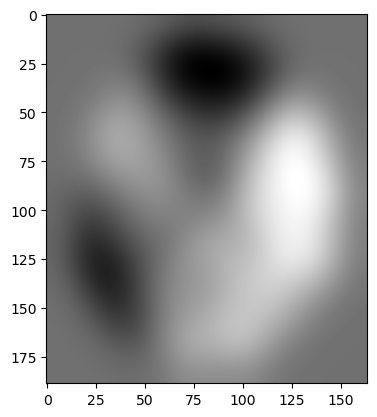

In [17]:
plt.imshow(bias,cmap='grey')
plt.show()

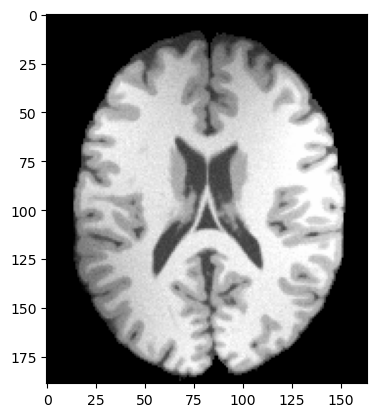

In [18]:
plt.imshow(testimage,cmap='grey')
plt.show()

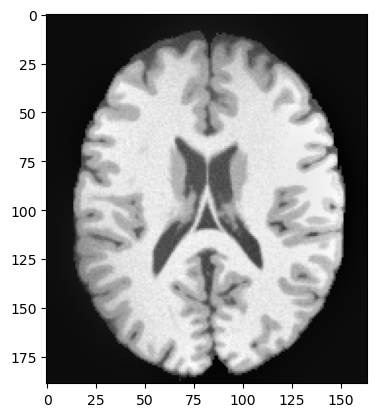

In [19]:
res=img_gray-bias
plt.imshow(res,cmap='grey')
plt.show()

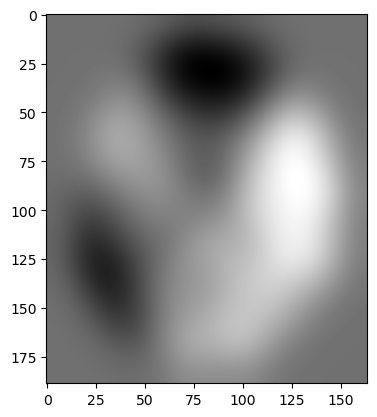

In [20]:
plt.imshow(img_gray-res,cmap='gray')
plt.show()